Based on the Multi-Agent Reinforcement Learning (PPO) with TorchRL Tutorial by Matteo Bettini

Can be found here : https://pytorch.org/rl/tutorials/multiagent_ppo.html

In [49]:
!pip3 install torchrl
!pip3 install vmas==1.2.11
!pip3 install tqdm

In [50]:
# Torch
import torch

from tensordict.nn import TensorDictModule, InteractionType
from tensordict.nn.distributions import NormalParamExtractor

# Tensordict modules
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

In [51]:
# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration
n_iters = 20  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 30  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate

In [52]:
max_steps = 100  # Episode steps before done
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
scenario_name = "navigation"
n_agents = 3

env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,  # VMAS supports both continuous and discrete actions
    max_steps=max_steps,
    device=vmas_device,
    # Scenario kwargs
    n_agents=n_agents,  # These are custom kwargs that change for each VMAS scenario, see the VMAS repo to know more.
)

In [53]:
print("action_spec:", env.full_action_spec)
print("reward_spec:", env.full_reward_spec)
print("done_spec:", env.full_done_spec)
print("observation_spec:", env.observation_spec)

action_spec: CompositeSpec(
    agents: CompositeSpec(
        action: BoundedTensorSpec(
            shape=torch.Size([60, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous), device=cpu, shape=torch.Size([60, 3])), device=cpu, shape=torch.Size([60]))
reward_spec: CompositeSpec(
    agents: CompositeSpec(
        reward: UnboundedContinuousTensorSpec(
            shape=torch.Size([60, 3, 1]),
            space=None,
            device=cpu,
            dtype=torch.float32,
            domain=continuous), device=cpu, shape=torch.Size([60, 3])), device=cpu, shape=torch.Size([60]))
done_spec: CompositeSpec(
    done: DiscreteTensorSpec(
        shape=torch.Size([60, 1]),
        space=DiscreteBox(n=

In [54]:
print("action_keys:", env.action_keys)
print("reward_keys:", env.reward_keys)
print("done_keys:", env.done_keys)

action_keys: [('agents', 'action')]
reward_keys: [('agents', 'reward')]
done_keys: ['done', 'terminated']


In [55]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

In [56]:
check_env_specs(env)

2024-02-23 19:19:43,586 [torchrl][INFO] check_env_specs succeeded!


In [57]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 5, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        final_rew: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        pos_rew: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([60, 5, 3]),
                    device=cpu,
                    is_shared=False),
                observation: Tensor(shape=torch.Size([60, 5, 3, 18]), device=cpu, dtype=torc

In [58]:
!sudo apt-get update
!sudo apt-get install -y x11-utils
!sudo apt-get install -y xvfb
%pip install pyvirtualdisplay
!sudo apt-get install -y python3-opengl

Hit:1 https://packages.microsoft.com/repos/microsoft-ubuntu-focal-prod focal InRelease
Hit:2 https://dl.yarnpkg.com/debian stable InRelease                           
Hit:3 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable InRelease       
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease               
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease                 
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease      
0% [Connected to packagecloud.io (50.18.221.59)]                      

Hit:8 https://packagecloud.io/github/git-lfs/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+5).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.15).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-opengl is already the newest version (3.1.0+dfsg-2build1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


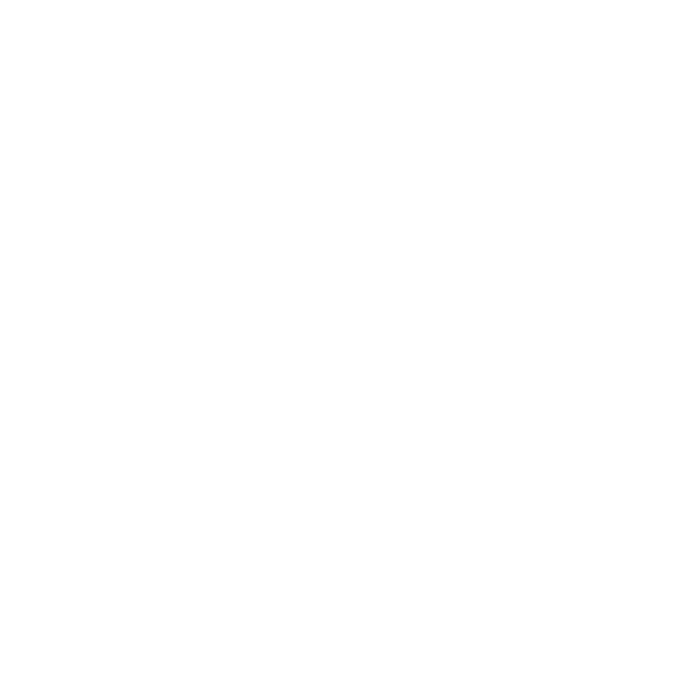

In [59]:
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()
from PIL import Image

def rendering_callback(env, td):
    env.frames.append(Image.fromarray(env.render(mode="rgb_array")))
env.frames = []
with torch.no_grad():
   env.rollout(
       max_steps=max_steps,
       callback=rendering_callback,
       auto_cast_to_device=True,
       break_when_any_done=False,
   )
env.frames[0].save(
    f"{scenario_name+'random_policy'}.gif",
    save_all=True,
    append_images=env.frames[1:],
   duration=3,
   loop=0,
)

from IPython.display import Image
Image(open(f"{scenario_name+'random_policy'}.gif", "rb").read())

In [60]:
share_parameters_policy = True # whether we want our agents to share the policy parameters.
# On the one hand, sharing parameters means that they will all share the same policy, which will allow them to benefit from each other’s experiences.
# This will also result in faster training. On the other hand, it will make them behaviorally homogenous, as they will in fact share the same model.
centralised_policy = False # wether the policies are centralised (False means each agent will act from its own observation)

## Sharing the critic parameters
In general, critic parameters sharing will grant faster training convergence, but there are a few important considerations to be made:
- Sharing is not recommended when agents have different reward functions, as the critics will need to learn to assign different values to the same state (e.g., in mixed cooperative-competitive settings).
- In decentralised training settings, sharing cannot be performed without additional infrastructure to synchronise parameters.

In all other cases where the reward function (to be differentiated from the reward) is the same for all agents (as in the current scenario), sharing can provide improved performance. This can come at the cost of homogeneity in the agent strategies. In general, the best way to know which choice is preferable is to quickly experiment both options.


In any case, the critic output will have shape (..., n_agents, 1). If the critic is centralised and shared, all the values along the n_agents dimension will be identical.

In [61]:
share_parameters_Qvalues = True 
centralised_Qvalues = True 

In [62]:
# Model
layers_config = [256, 256, 64]

In [63]:
print('observation size (x and y position, x and y velocity, 12 lidar readings, and x and y relative position to its goal) :', env.observation_spec["agents", "observation"].shape[-1])
print('action_size * 2 (mean and scale of a distribution) :', 2 * env.action_spec.shape[-1])

MultiAgentMultiLayerPerceptron = MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=2 * env.action_spec.shape[-1],  # 2 * n_actions_per_agents
        n_agents=env.n_agents,
        centralised=centralised_policy,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=len(layers_config),
        num_cells=layers_config,
        activation_class=torch.nn.LeakyReLU,
)

policy_net = torch.nn.Sequential(
    MultiAgentMultiLayerPerceptron,
    NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
)

print(MultiAgentMultiLayerPerceptron)
print(policy_net)

observation size (x and y position, x and y velocity, 12 lidar readings, and x and y relative position to its goal) : 18
action_size * 2 (mean and scale of a distribution) : 4
MultiAgentMLP(
  (agent_networks): ModuleList(
    (0): MLP(
      (0): Linear(in_features=18, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=64, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)
Sequential(
  (0): MultiAgentMLP(
    (agent_networks): ModuleList(
      (0): MLP(
        (0): Linear(in_features=18, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Linear(in_features=256, out_features=64, bias=True)
      

In [64]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)
print(policy_module)

TensorDictModule(
    module=Sequential(
      (0): MultiAgentMLP(
        (agent_networks): ModuleList(
          (0): MLP(
            (0): Linear(in_features=18, out_features=256, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Linear(in_features=256, out_features=64, bias=True)
            (5): LeakyReLU(negative_slope=0.01)
            (6): Linear(in_features=64, out_features=4, bias=True)
          )
        )
      )
      (1): NormalParamExtractor()
    ),
    device=cpu,
    in_keys=[('agents', 'observation')],
    out_keys=[('agents', 'loc'), ('agents', 'scale')])


In [65]:
print(env.unbatched_action_spec)
print(env.action_key)

CompositeSpec(
    agents: CompositeSpec(
        action: BoundedTensorSpec(
            shape=torch.Size([3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([3, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([3, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous), device=cpu, shape=torch.Size([3])), device=cpu, shape=torch.Size([]))
('agents', 'action')


In [66]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.unbatched_action_spec,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.unbatched_action_spec[env.action_key].space.low,
        "max": env.unbatched_action_spec[env.action_key].space.high,
        "tanh_loc": False,
    },
    default_interaction_type=InteractionType.RANDOM,
    return_log_prob=False,
)
print("Running policy:", policy(env.reset()))

Running policy: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        final_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        pos_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([60, 3]),
                    device=cpu,
                    is_shared=False),
                loc: Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
         

Q(s, a) parametric model

In [67]:
print("observation size :", env.observation_spec["agents", "observation"].shape[-1])
print("action size :", env.unbatched_action_spec['agents', 'action'].shape[-1])

observation size : 18
action size : 2


In [68]:
Qval_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1] + env.unbatched_action_spec['agents', 'action'].shape[-1],
    n_agent_outputs=1,  # 1 value per agent
    n_agents=env.n_agents,
    centralised=centralised_Qvalues,
    share_params=share_parameters_Qvalues,
    device=device,
    depth=len(layers_config),
    num_cells=layers_config,
    activation_class=torch.nn.LeakyReLU,

)

Qval = TensorDictModule(
    module=Qval_net,
    out_keys=[("agents", "state_action_value")],
    in_keys=[("agents", "observation"), ("agents", "action")],
)
print(Qval)

TensorDictModule(
    module=MultiAgentMLP(
      (agent_networks): ModuleList(
        (0): MLP(
          (0): Linear(in_features=60, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Linear(in_features=256, out_features=64, bias=True)
          (5): LeakyReLU(negative_slope=0.01)
          (6): Linear(in_features=64, out_features=1, bias=True)
        )
      )
    ),
    device=cpu,
    in_keys=[('agents', 'observation'), ('agents', 'action')],
    out_keys=[('agents', 'state_action_value')])


In [69]:
# Reset the environment to get initial observations
initial_env_output = env.reset()

# Generate dummy actions. The shape and values should be compatible with the environment's action space.
# Here, I'm assuming the action space is continuous and bounded. Adjust this according to your specific environment.
dummy_actions = torch.rand((num_vmas_envs, n_agents, env.action_spec.shape[-1]), device=device)
# Add the dummy actions to the TensorDict under the correct key
initial_env_output.set(('agents', "action"), dummy_actions)

# Now you can run Qval with the updated TensorDict
print("Running Q:", Qval(initial_env_output))

Running Q: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        final_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        pos_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([60, 3]),
                    device=cpu,
                    is_shared=False),
                observation: Tensor(shape=torch.Size([60, 3, 18]), device=cpu, dtype=torch.float32, is_shared=False),
     

## Data collector
TorchRL provides a set of data collector classes. Briefly, these classes execute three operations: reset an environment, compute an action using the policy and the latest observation, execute a step in the environment, and repeat the last two steps until the environment signals a stop (or reaches a done state).

We will use the simplest possible data collector, which has the same output as an environment rollout, with the only difference that it will auto reset done states until the desired frames are collected.

In [70]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    init_random_frames=frames_per_batch,
    total_frames=total_frames,
)

In [71]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)

## SAC Loss function

Soft Actor Critic (SAC) is an algorithm that optimizes a stochastic policy in an off-policy way, forming a bridge between stochastic policy optimization and DDPG-style approaches. It isn’t a direct successor to TD3 (having been published roughly concurrently), but it incorporates the clipped double-Q trick, and due to the inherent stochasticity of the policy in SAC, it also winds up benefiting from something like target policy smoothing.

A central feature of SAC is entropy regularization. The policy is trained to maximize a trade-off between expected return and entropy, a measure of randomness in the policy. This has a close connection to the exploration-exploitation trade-off: increasing entropy results in more exploration, which can accelerate learning later on. It can also prevent the policy from prematurely converging to a bad local optimum.

- https://spinningup.openai.com/en/latest/algorithms/sac.html
- https://pytorch.org/rl/reference/generated/torchrl.objectives.SACLoss.html

In [72]:
from torchrl.objectives.sac import SACLoss
from torchrl.objectives import SoftUpdate

In [ ]:
# SAC
value_loss='smooth_l1' # 'smooth_l1' 'mse' ; loss function to be used with the value function loss
gamma = 0.9  # discount factor
polyak = 0.002 # lambda for generalised advantage estimation

In [74]:
loss_module = SACLoss(
    actor_network=policy,
    qvalue_network=Qval,
    loss_function=value_loss,
    action_spec=env.action_spec
)
loss_module.make_value_estimator(gamma=gamma)
target_net_updater = SoftUpdate(loss_module, eps=polyak)
optim = torch.optim.Adam(loss_module.parameters(), lr)

/home/codespace/.python/current/lib/python3.10/site-packages/torchrl/objectives/utils.py:313: UserWarning: Found an eps value < 0.5, which is unexpected. You may want to use the `tau` keyword argument instead.
  warnings.warn(


## Setting up the keys for the loss module computations
keys needs to be reassigned in the nested agent upper key

In [75]:
loss_module.set_keys(action=("agents", "action"), reward=("agents", "episode_reward"), terminated=("next", "agents", "terminated"), done=("agents", "done"), state_action_value=("agents", "state_action_value"), priority=("agents", "td_error"))

## SAC loss implementation
the main torchrl SAC implementation guided me :

https://github.com/xmaples/pytorchrl/blob/83cd864666d2f83efe4f7bb66028ffd026976e9d/examples/sac/sac.py#L29

In [76]:
rewards = []
rewards_eval = []

# Main loop
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

q_loss = None

episode_reward_mean_list = []

for tensordict_data in collector:
    #print("tensordict_data :", tensordict_data)
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)
    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    #print("reward :", tensordict_data.get_item_shape(("next", "agents", "reward")))

    data_view.pop(('done'))
    replay_buffer.extend(data_view)

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()

            #print("subdata :", subdata)

            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_actor"]
                + loss_vals["loss_qvalue"]
                + loss_vals["loss_alpha"]
            )

            optim.zero_grad()
            loss_value.backward()
            optim.step()

            # update qnet_target params
            target_net_updater.step()

    # update weights of the inference policy
    collector.update_policy_weights_()

    # Logging
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = 1.4281989336013794: 100%|██████████| 10/10 [15:37<00:00, 93.70s/it]


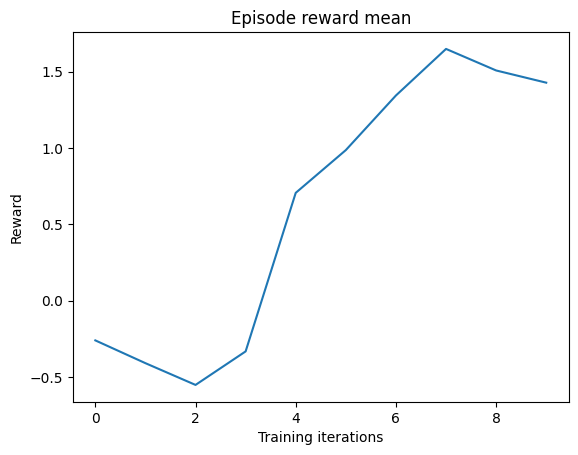

In [ ]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.savefig('Episode reward mean', format='png')
plt.show()

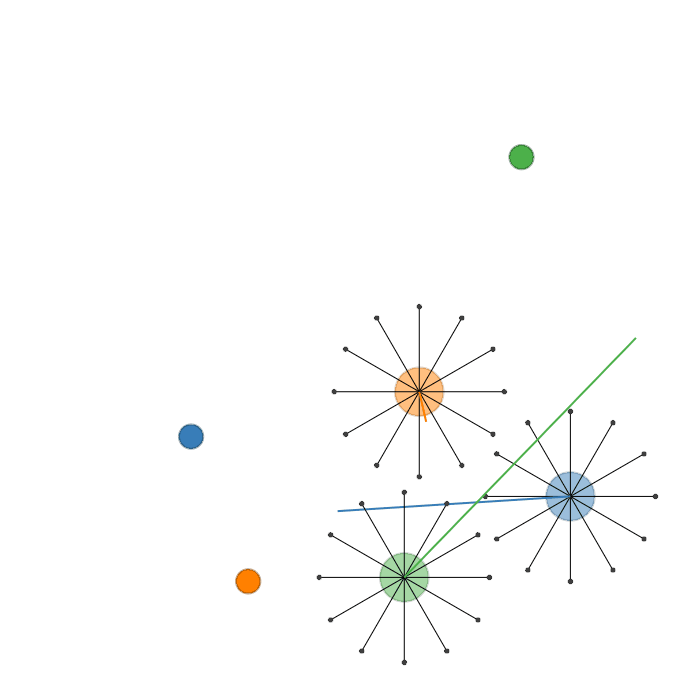

In [ ]:
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()
from PIL import Image

def rendering_callback(env, td):
    env.frames.append(Image.fromarray(env.render(mode="rgb_array")))
env.frames = []
with torch.no_grad():
   env.rollout(
       max_steps=max_steps,
       policy=policy,
       callback=rendering_callback,
       auto_cast_to_device=True,
       break_when_any_done=False,
   )
env.frames[0].save(
    f"{scenario_name}.gif",
    save_all=True,
    append_images=env.frames[1:],
   duration=3,
   loop=0,
)

from IPython.display import Image
Image(open(f"{scenario_name}.gif", "rb").read())